# Concensus NMF running script

#### similar as described by cNMF team on github: https://github.com/dylkot/cNMF/blob/master/Tutorials/analyze_pbmc_example_data.ipynb

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
#from IPython.display import Imaged
import scanpy as sc
from cnmf import cNMF
import anndata as ad

np.random.seed(42)

In [2]:
# Read GeoMx counts
dsp_count = pd.read_csv('~/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/tonsil_count.csv')

dsp_count.shape

(330, 18677)

In [3]:
dsp_count

,DBF4,AKAP5,CAPZA2,GIGYF1,MCCC2,TMX1,NSMAF,HNRNPLL,TAC4,HMX3,...,EPHA5,MYO1G,MSMO1,SMG1,TXNDC9,HIKESHI,KYAT1,SETX,KLHL41,DNAJC13
0,4.851101,5.750246,7.044151,4.515418,6.196312,5.927428,5.702852,6.962521,4.856947,5.149604,...,5.569222,6.657143,4.779317,6.555356,4.803993,5.422021,6.321166,6.637454,4.953337,5.866807
1,6.364631,4.632842,6.099854,4.557738,5.280213,5.839137,5.152429,5.318129,4.699482,5.031029,...,4.272062,7.081168,4.290919,6.752343,6.898316,6.563391,5.362262,6.951002,6.535073,5.327949
2,5.875442,5.081995,5.553547,5.126747,5.193765,5.898124,4.780096,5.851298,4.461840,5.920951,...,4.915887,7.102735,3.788353,5.302975,5.512370,5.777853,5.329021,6.490003,6.281926,4.913329
3,5.161544,3.324353,6.253428,5.024862,4.907626,5.822661,4.675396,6.257120,4.032368,4.243099,...,5.356217,7.010883,4.951264,6.015787,6.521194,5.934533,4.741424,5.596518,5.891737,3.303897
4,5.353140,5.078005,4.884311,4.113543,4.028744,5.395952,5.233969,5.216158,4.761193,5.275198,...,3.808937,6.952260,4.412922,6.426316,5.734082,6.999815,4.488509,5.474617,5.774546,5.411502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,5.380206,5.329957,5.517977,5.632980,5.033335,5.250939,5.827573,5.579102,4.211812,5.025082,...,5.299055,7.401087,4.884352,6.358115,6.076387,6.319654,5.242180,6.482749,6.067748,5.369972
326,5.828914,4.913662,6.311541,5.186067,5.446811,6.050705,5.171750,6.390650,4.757015,5.393717,...,5.508291,7.778797,4.915715,6.263627,6.319098,6.275221,5.421982,6.728883,6.208221,5.455006
327,6.112499,5.230690,6.069464,5.134974,5.541781,5.996372,5.347501,6.029151,4.916076,4.931971,...,4.345168,7.309409,4.339553,6.386026,6.028317,6.675143,5.414474,6.570757,6.099528,4.823884
328,5.912909,5.460898,5.953977,5.547894,5.564965,5.887115,5.584593,5.567205,5.235194,5.322827,...,4.973310,7.457759,5.050016,6.433513,6.271373,6.657429,5.578373,6.852031,5.806272,5.398523


In [4]:
# Remove the negative control probes
dsp_count2 = dsp_count
dsp_count2 = dsp_count2[dsp_count2.columns.drop(list(dsp_count2.filter(regex='Neg')))]

dsp_count2.shape

(330, 18676)

In [5]:
# Save annotated data into .h5ad file format
dsp = ad.AnnData(
    dsp_count2.to_numpy(), dtype=np.float32
)
dsp

save = '/mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/tonsil.h5ad'
sc.write(save, dsp)

/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [6]:
# Prepare cNMF parameters
seed = 123 ## Specify a seed pseudorandom number generation for reproducibility

numiter = 500 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numhvgenes = 2000 ## Number of high variable genes to use for running the actual factorizations

# Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = '/mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'cnmf_tonsil'

## Specify the Ks to use as a space separated list in this case "5 6 7 8 9 10"
K = ' '.join([str(i) for i in range(25,30,1)])

In [7]:
# Initialize the cnmf object that will be used to run analyses
cnmf_obj = cNMF(output_dir=output_directory,
                name=run_name)

In [8]:
## Prepare the data, i.e. subset to n high-variance genes, and variance normalize
cnmf_obj.prepare(counts_fn=save, components=range(25,30,1),
                 n_iter=numiter, seed=seed, num_highvar_genes=numhvgenes)

In [9]:
# Next is the factorization step which runs NMF –n-iter times for each value of K.
# Here we run all these jobs sequentially on a single worker (worker-i=1) and then launch that worker

# In theory this can be distributed to multiple cores or nodes with separate commands like so, which breaks factorization jobs up into 3 batches
# This can be used with compute clusters to run the factorizations in parallel:
#cnmf factorize --output-dir ./example_data --name example_cNMF --worker-index 0 --total-workers 3 &
#cnmf factorize --output-dir ./example_data --name example_cNMF --worker-index 1 --total-workers 3 &
#cnmf factorize --output-dir ./example_data --name example_cNMF --worker-index 2 --total-workers 3 &

cnmf_obj.factorize(worker_i=0, total_workers=5)

[Worker 0]. Starting task 0.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 5.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 10.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 15.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 20.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 25.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 30.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 35.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 40.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 45.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 50.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 55.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 60.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 65.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 70.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 75.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 80.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 85.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 90.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 95.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 100.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 105.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 110.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 115.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 120.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 125.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 130.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 135.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 140.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 145.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 150.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 155.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 160.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 165.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 170.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 175.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 180.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 185.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 190.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 195.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 200.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 205.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 210.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 215.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 220.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 225.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 230.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 235.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 240.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 245.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 250.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 255.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 260.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 265.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 270.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 275.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 280.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 285.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 290.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 295.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 300.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 305.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 310.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 315.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 320.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 325.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 330.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 335.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 340.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 345.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 350.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 355.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 360.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 365.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 370.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 375.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 380.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 385.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 390.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 395.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 400.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 405.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 410.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 415.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 420.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 425.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 430.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 435.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 440.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 445.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 450.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 455.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 460.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 465.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 470.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 475.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 480.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 485.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 490.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 495.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 500.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 505.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 510.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 515.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 520.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 525.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 530.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 535.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 540.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 545.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 550.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 555.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 560.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 565.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 570.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 575.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 580.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 585.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 590.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 595.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 600.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 605.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 610.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 615.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 620.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 625.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 630.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 635.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 640.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 645.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 650.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 655.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 660.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 665.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 670.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 675.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 680.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 685.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 690.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 695.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 700.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 705.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 710.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 715.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 720.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 725.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 730.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 735.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 740.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 745.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 750.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 755.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 760.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 765.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 770.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 775.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 780.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 785.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 790.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 795.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 800.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 805.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 810.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 815.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 820.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 825.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 830.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 835.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 840.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 845.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 850.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 855.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 860.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 865.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 870.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 875.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 880.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 885.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 890.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 895.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 900.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 905.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 910.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 915.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 920.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 925.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 930.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 935.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 940.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 945.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 950.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 955.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 960.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 965.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 970.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 975.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 980.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 985.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 990.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 995.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1000.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1005.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1010.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1015.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1020.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1025.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1030.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1035.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1040.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1045.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1050.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1055.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1060.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1065.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1070.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1075.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1080.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1085.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1090.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1095.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1100.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1105.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1110.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1115.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1120.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1125.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1130.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1135.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1140.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1145.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1150.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1155.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1160.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1165.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1170.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1175.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1180.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1185.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1190.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1195.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1200.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1205.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1210.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1215.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1220.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1225.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1230.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1235.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1240.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1245.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1250.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1255.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1260.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1265.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1270.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1275.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1280.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1285.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1290.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1295.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1300.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1305.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1310.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1315.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1320.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1325.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1330.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1335.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1340.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1345.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1350.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1355.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1360.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1365.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1370.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1375.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1380.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1385.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1390.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1395.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1400.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1405.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1410.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1415.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1420.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1425.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1430.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1435.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1440.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1445.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1450.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1455.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1460.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1465.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1470.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1475.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1480.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1485.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1490.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1495.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1500.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1505.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1510.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1515.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1520.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1525.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1530.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1535.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1540.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1545.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1550.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1555.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1560.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1565.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1570.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1575.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1580.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1585.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1590.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1595.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1600.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1605.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1610.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1615.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1620.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1625.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1630.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1635.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1640.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1645.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1650.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1655.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1660.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1665.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1670.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1675.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1680.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1685.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1690.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1695.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1700.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1705.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1710.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1715.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1720.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1725.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1730.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1735.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1740.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1745.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1750.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1755.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1760.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1765.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1770.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1775.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1780.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1785.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1790.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1795.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1800.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1805.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1810.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1815.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1820.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1825.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1830.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1835.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1840.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1845.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1850.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1855.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1860.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1865.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1870.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1875.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1880.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1885.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1890.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1895.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1900.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1905.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1910.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1915.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1920.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1925.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1930.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1935.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1940.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1945.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1950.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1955.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1960.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1965.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1970.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1975.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1980.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1985.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1990.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 1995.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2000.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2005.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2010.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2015.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2020.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2025.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2030.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2035.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2040.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2045.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2050.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2055.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2060.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2065.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2070.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2075.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2080.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2085.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2090.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2095.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2100.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2105.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2110.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2115.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2120.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2125.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2130.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2135.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2140.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2145.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2150.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2155.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2160.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2165.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2170.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2175.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2180.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2185.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2190.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2195.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2200.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2205.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2210.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2215.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2220.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2225.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2230.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2235.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2240.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2245.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2250.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2255.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2260.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2265.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2270.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2275.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2280.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2285.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2290.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2295.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2300.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2305.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2310.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2315.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2320.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2325.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2330.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2335.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2340.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2345.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2350.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2355.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2360.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2365.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2370.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2375.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2380.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2385.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2390.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2395.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2400.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2405.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2410.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2415.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2420.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2425.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2430.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2435.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2440.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2445.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2450.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2455.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2460.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2465.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2470.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2475.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2480.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2485.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2490.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


[Worker 0]. Starting task 2495.


/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


In [10]:
# Next we concatenate the results for each value of K into a single file
cnmf_obj.combine(skip_missing_files = True)

Combining factorizations for k=25.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_25.iter_1.df.npz. Skipping.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_25.iter_2.df.npz. Skipping.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_25.iter_3.df.npz. Skipping.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_25.iter_4.df.npz. Skipping.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_25.iter_6.df.npz. Skipping.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_25.

Combining factorizations for k=27.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_27.iter_1.df.npz. Skipping.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_27.iter_2.df.npz. Skipping.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_27.iter_3.df.npz. Skipping.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_27.iter_4.df.npz. Skipping.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_27.iter_6.df.npz. Skipping.
Missing file: /mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/cnmf_tonsil/cnmf_tmp/cnmf_tonsil.spectra.k_27.

/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


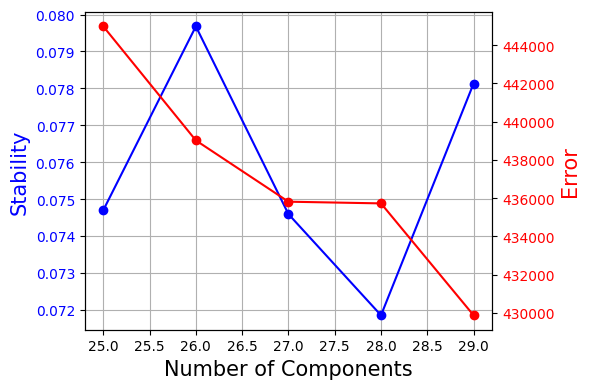

In [11]:
# And make a plot estimating the trade-off between higher values of K and stability and error
cnmf_obj.k_selection_plot(close_fig=False)

/opt/miniconda3/envs/cNMF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


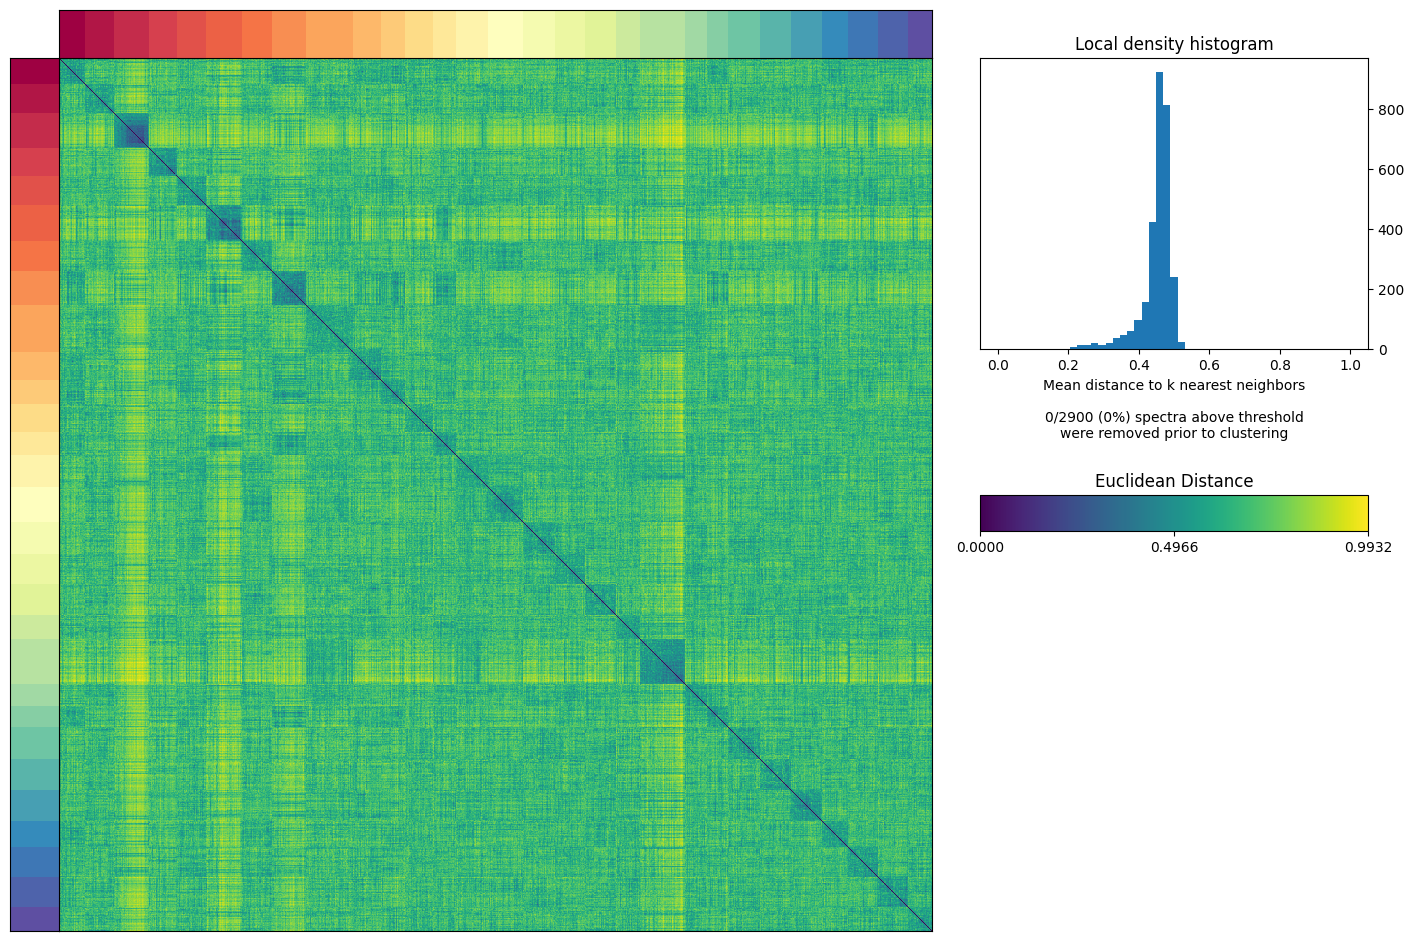

In [20]:
# Pick the K that gives the highest stability and lowest error
selected_K = 29

# This step creates a plot to help visualize the consensus clustering
density_threshold = 2.00
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)

In [21]:
# Load cNMF clustering results
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=selected_K, density_threshold=density_threshold)

usage_norm.columns = ['Usage_%d' % i for i in usage_norm.columns]
usage_norm.index = dsp_count.index
usage_norm

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7,Usage_8,Usage_9,Usage_10,...,Usage_20,Usage_21,Usage_22,Usage_23,Usage_24,Usage_25,Usage_26,Usage_27,Usage_28,Usage_29
0,0.156986,0.110670,0.042671,0.018652,0.012641,0.042297,0.048033,0.081341,0.091266,0.061420,...,0.010844,0.102287,0.000000,0.017604,0.000000,0.003819,0.000000,0.025752,0.005847,0.038349
1,0.155206,0.089506,0.021304,0.036216,0.267421,0.017786,0.030388,0.018667,0.030774,0.056870,...,0.048680,0.004626,0.000000,0.005643,0.032246,0.009712,0.042214,0.000000,0.000000,0.011062
2,0.000000,0.162706,0.040785,0.055167,0.105343,0.052321,0.000000,0.000000,0.022369,0.101675,...,0.000000,0.034623,0.062579,0.003892,0.000000,0.000000,0.091161,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.041120,0.124754,0.000000,0.036961,0.053714,0.000000,...,0.000000,0.137963,0.106210,0.000000,0.000000,0.042040,0.027914,0.000000,0.000000,0.104973
4,0.101870,0.008126,0.000000,0.001786,0.000000,0.000000,0.047587,0.043647,0.094970,0.001802,...,0.002153,0.127299,0.138785,0.000000,0.032054,0.000000,0.000000,0.022404,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0.054621,0.056218,0.049042,0.028902,0.057418,0.086179,0.092230,0.009225,0.027750,0.064010,...,0.016033,0.022142,0.029394,0.014147,0.048029,0.002925,0.000039,0.019458,0.018634,0.015889
326,0.060140,0.021227,0.057133,0.069868,0.034622,0.053845,0.048796,0.000157,0.008034,0.045277,...,0.022666,0.042795,0.014651,0.010155,0.013448,0.000000,0.030868,0.042853,0.000733,0.017334
327,0.057333,0.046312,0.074415,0.058505,0.141713,0.077254,0.065534,0.000967,0.026507,0.034722,...,0.016800,0.023423,0.057285,0.053888,0.022176,0.001861,0.000000,0.010818,0.009252,0.000000
328,0.072574,0.072627,0.069350,0.050640,0.049204,0.077533,0.080302,0.038418,0.030572,0.055534,...,0.016840,0.007853,0.029101,0.018460,0.027529,0.006528,0.006947,0.018311,0.000000,0.013825


In [22]:
# Save to .csv
usage_norm.to_csv('/mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/tonsil_cnmf29_usage.csv')

In [23]:
# To make sense of the learned GEPs, we extract the top highly-weighted genes for each GEP
print(gep_scores.shape)
topgenes.head(10)

(18676, 29)


,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
0,7611,18588,847,7171,10249,2469,5049,16705,834,13742,...,9680,11200,2469,5103,1323,2196,11860,12185,4057,16545
1,14556,4816,14416,17045,7033,1062,16995,10570,7695,16460,...,9259,11339,9957,2469,7957,17174,16158,11217,16498,7765
2,11033,15546,11145,10549,6367,5103,4574,17482,3318,36,...,12959,15024,16469,717,991,12089,7745,16953,14304,9659
3,9367,17369,15846,5679,7203,5931,2667,6982,15885,14947,...,4848,16404,18201,16946,8540,5721,18540,1666,2487,8719
4,3221,11650,9688,7728,8838,5754,17915,1762,3686,10779,...,10150,3050,3061,11289,8104,6112,8763,13561,15230,5376
5,13880,2441,13393,10225,3787,8921,10225,15955,10426,12568,...,3225,1367,6007,5754,3703,9891,1441,15407,9887,8660
6,16990,15141,17700,11697,208,4297,17050,4057,5128,4339,...,11402,2,4554,7552,8677,14858,236,14844,18342,5462
7,3672,344,6559,14701,969,3863,14919,14186,17794,15809,...,11189,18217,3863,1062,1396,7503,10061,11154,6569,6409
8,17169,9329,4138,14277,1729,14281,7171,16131,2263,9765,...,7524,1615,5103,7710,13337,16485,8401,13043,8383,12434
9,16791,10347,11708,7283,1494,7552,9463,1852,11639,4565,...,3699,5567,12098,4500,9256,18383,1344,13448,15383,6075


In [24]:
# Here we extract the top 100 genes
dd = {}
genelist = dsp_count2.columns.tolist()
for i in range(29): # change based on number of columns
    dd[i] = []
    #print(i)
    for j in range(100):
        #print(j)
        id = int(topgenes.iloc[j,i])
        gene = genelist[id]
        dd[i].append(gene)
df = pd.DataFrame.from_dict(dd)

df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,CKAP2,DEFB129,POU3F2,LYPD6,H2AZ1,CNFN,TAS2R60,GPBP1L1,IL32,HHIP,...,XPO6,METTL26,CNFN,PI3,IDO1,CAMP,ABCA9,MAP7D3,CDK10,MUC2
1,EXOSC10,ATP12A,SAMD3,MFSD3,H4C15,SPRR1B,STX1B,PNMA6E,SIRPG,ACSM2B,...,MOSPD1,IFNA16,KLK10,CNFN,CEMIP,MCIDAS,SIGLEC15,SLFN14,PLA2R1,CALCR
2,EML6,PRDM11,GZMH,LAT,H4C13,PI3,LDHC,GOLGA7B,LAG3,NPBWR1,...,ATP6V1B1,TAGLN3,FOXN1,PLA2G2F,TUBB2B,WFIKKN1,SPTA1,TMOD4,ZNF300,OR8S1
3,H2BC3,MYO1A,SLITRK6,ZCCHC10,H4C4,MMP7,ZNF444,RNF144A,PYHIN1,LRRC71,...,TMC5,CARD8,ESRP1,MAFF,CDKN1A,PRDM8,TRIM63,CCDC15,NXF1,BFSP2
4,H2AC6,STK31,GP2,KRTAP5-8,H1-5,SBSN,MAMLD1,PKDREJ,ZAP70,OR6X1,...,C11orf54,ARNTL,MAB21L4,SPRR3,MT3,MRPL39,SPACA1,SMIM1,OPTC,UCP1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BUB1B,CAPN11,BNIP5,ICA1,HNRNPC,CLDN4,OR2T8,SLC39A5,ARHGEF1,DTHD1,...,FAM71F1,ST6GALNAC6,EMP2,THEG,PRDM5,RCL1,HOXA6,ARSG,CTRB2,INHBC
96,BAZ1B,IRX1,GAP43,AKAP1,HSP90AB1,IL36A,CFHR2,BRD4,TRIB2,MAN1B1,...,TPBG,ABCG8,DAAM1,ZFP36,RAPSN,IGSF11,WDCP,NKX6-1,ZAN,SERPINE3
97,CIRBP,INO80,MICU3,PBXIP1,RAN,CALML3,ZNF69,ZBTB44,TNIP3,OSCP1,...,GPR142,L3MBTL3,ANXA9,MINK1,INSR,SPATS1,AZU1,TSPAN10,TIGAR,GAL3ST4
98,MAST2,REN,PRL,NUTM2G,H2AC15,CMTM4,EXTL2,PSMA7,CD69,FCRL2,...,ORAI1,TMA16,SPINT1,KLK10,OR2T8,ANGPTL5,EIF4E3,FTHL17,CA12,ISLR2


In [25]:
# Save to .csv
df.to_csv('/mnt/nfs/home/yaoyuyeo/IN_DEPTH/Tonsil_Experiment/Tonsil_Analysis/cNMF_tutorial/tonsil_top100_genes_cnmf29.csv', index = False)